In [113]:
import pandas as pd
import numpy as np

file_path ='einkommen.train'

data = pd.read_csv(file_path)

In [115]:
column_names = [
    'Age',
    'Employment type',
    'Weighting factor',
    'Level of education',
    'Schooling/training period',
    'Marital status',
    'Employment area',
    'Partnership',
    'Ethnicity',
    'Gender',
    'Gains on financial assets',
    'Losses on financial assets',
    'Weekly working time',
    'Country of birth',
    'Income'
]

#Add column names to DataFrame 
df = pd.read_csv('einkommen.train', names=column_names)

**Properties of Data**

In [118]:
#Count class distribution 

unique_counts = {}
for val in df['Income'].unique():
    count = df['Income'].value_counts()[val]
    unique_counts[val] = count
print(unique_counts)

{' <=50K': 3779, ' >50K': 1221, ' ?': 25000}


In [120]:
#Count the rows with missing values

#Clean up string data 
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

df_woi = df.drop('Income', axis=1)

missing_value_rows = df_woi[df_woi.apply(lambda row: any(val == '?' for val in row), axis=1)]

len(missing_value_rows)

2196

In [121]:
#Count how many missing values in each column

def count_question_marks(series):
    return (series == '?').sum()

missing_value_counts = df_woi.apply(count_question_marks)

print(missing_value_counts)

Age                              0
Employment type               1677
Weighting factor                 0
Level of education               0
Schooling/training period        0
Marital status                   0
Employment area               1682
Partnership                      0
Ethnicity                        0
Gender                           0
Gains on financial assets        0
Losses on financial assets       0
Weekly working time              0
Country of birth               539
dtype: int64


**Preprocessing the data**

In [125]:
#Replace missing values('?') with NaN

df.replace({'?': np.nan}, inplace=True)

In [127]:
# Replacing missing values in the DataFrame:
# For columns with categorical data types, fill missing values with the most frequent value.
# For numerical columns, fill missing values with the median.

from sklearn.preprocessing import OneHotEncoder, StandardScaler

for column in df_woi.columns:
    if df_woi[column].dtype == 'object':
        df_woi[column] = df_woi[column].fillna(df_woi[column].mode()[0])
    else:
        df_woi[column] = df_woi[column].fillna(df_woi[column].median())

In [129]:
#Transform the data for model training and testing 

# One-Hot Encoding for categorical variables
categorical_cols = ['Employment type', 
                    'Level of education', 
                    'Marital status', 
                    'Employment area', 
                    'Partnership', 
                    'Ethnicity', 
                    'Gender', 
                    'Country of birth']

one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')

encoded_cats = one_hot_encoder.fit_transform(df_woi[categorical_cols])

encoded_cats_df = pd.DataFrame(encoded_cats, 
                               columns=one_hot_encoder.get_feature_names_out(categorical_cols))

In [131]:
# Normalization for numerical features
numerical_cols = ['Age', 
                   'Weighting factor', 
                    'Schooling/training period', 
                    'Gains on financial assets', 
                    'Losses on financial assets', 
                    'Weekly working time']

scaler = StandardScaler()

normalized_numerical_df = pd.DataFrame(scaler.fit_transform(df_woi[numerical_cols]), 
                                       columns=numerical_cols)

In [133]:
# Concatenate the normalized numerical DataFrame with the one-hot encoded DataFrame

final_df = pd.concat([normalized_numerical_df.reset_index(drop=True), 
                      encoded_cats_df.reset_index(drop=True)], axis=1)

In [135]:
#Proccess the income column
final_df['Income'] = df['Income'] 

final_df_labeled = final_df[final_df['Income'].notna()]

encoded_income = one_hot_encoder.fit_transform(final_df_labeled['Income'].values.reshape(-1, 1))

final_df_labeled['Income'] = encoded_income

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_21208\1193457992.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_labeled['Income'] = encoded_income


**Train and test three models**

In [138]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

#Create feature set and target variable for future modeling
features = final_df_labeled.drop('Income', axis=1)
target = final_df_labeled['Income']

#Split labeled data for train and test set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define class weights
class_weights = {0: 0.6617, 1: 2.0475}

**Logistic Regression**

In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Defining the hyperparameters to tune
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],        
    'solver': ['liblinear'],       
}

logistic_model = LogisticRegression(class_weight=class_weights, random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best hyperparameters found:")
print(grid_search.best_params_)

Best hyperparameters found:
{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [142]:
# Get the best Logistic Regression model from Grid Search

best_lr_model = grid_search.best_estimator_

**Random Forest**

In [144]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Definethe hyperparameters to tune
param_grid_rf = {
    'n_estimators': [10, 50, 100], 
    'max_depth': [None, 10, 20]   
}

random_forest_model = RandomForestClassifier(random_state=42, class_weight=class_weights)

# Perform Grid Search with Cross-Validation
grid_search_rf = GridSearchCV(estimator=random_forest_model, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print("Best hyperparameters found:")
print(grid_search_rf.best_params_)

Best hyperparameters found:
{'max_depth': None, 'n_estimators': 100}


In [147]:
# Get the best Random Forest model from Grid Search

best_rf_model = grid_search_rf.best_estimator_

**Neural Network**

In [209]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Set random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

#Reshape the indexes
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Function to create the neural network model with learning rate as a hyperparameter
def create_nn_model(learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  
    model.add(Dense(64, activation='relu'))  
    model.add(Dense(32, activation='relu'))  
    model.add(Dense(1, activation='sigmoid')) 
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define hyperparameters to tune
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
epochs = [10, 20, 30]

best_accuracy = 0
best_params = {}

# Iterate over hyperparameter combinations
for lr in learning_rates:
    for bs in batch_sizes:
        for ep in epochs:
            print(f"Training with lr={lr}, batch_size={bs}, epochs={ep}")
            
            model = create_nn_model(learning_rate=lr)
            
            model.fit(X_train, y_train, epochs=ep, batch_size=bs, class_weight=class_weights, verbose=0)
            
            y_pred_nn = (model.predict(X_test) > 0.5).astype("int32")
            accuracy = accuracy_score(y_test, y_pred_nn)
            
            print(f"Accuracy: {accuracy:.4f}")
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'learning_rate': lr, 'batch_size': bs, 'epochs': ep}

print("Best hyperparameters found:")
print(best_params)

Training with lr=0.001, batch_size=16, epochs=10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7890
Training with lr=0.001, batch_size=16, epochs=20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7880
Training with lr=0.001, batch_size=16, epochs=30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy: 0.7990
Training with lr=0.001, batch_size=32, epochs=10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.7910
Training with lr=0.001, batch_size=32, epochs=20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7870
Training with lr=0.001, batch_size=32, epochs=30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7820
Training with lr=0.001, batch_size=64, epochs=10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.8030
Training with lr=0.001, batch_size=64, epochs=20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.8030
Training with lr=0.001, batch_size=64, epochs=30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.8020
Training with lr=0.01, batch_size=16, epochs=10
32/32 ━

In [220]:
#Compile and train the best NN model

best_nn_model = create_nn_model(learning_rate=best_params['learning_rate'])

best_nn_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], class_weight=class_weights, verbose=1)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7118 - loss: 0.7308
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8051 - loss: 0.3844
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7896 - loss: 0.3757
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8091 - loss: 0.3669
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8147 - loss: 0.3554
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8217 - loss: 0.3334
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8337 - loss: 0.3283
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8450 - loss: 0.3230
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8451 - loss: 0.3116
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8543 - loss: 0.3000


In [222]:
# Test the best models

models = {
    "Logistic Regression": best_lr_model,
    "Random Forest": best_rf_model,
    "Neural Network": best_nn_model
}

results = {}

# Evaluate each model and store the results
for model_name, model in models.items():
  
    if model_name == "Neural Network":
        y_pred_proba = model.predict(X_test).flatten()  
        y_pred = (y_pred_proba > 0.5).astype(int) 
    else:
        y_pred_proba = model.predict_proba(X_test)[:, 1] 
        y_pred = (y_pred_proba > 0.5).astype(int) 

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)  
    
    results[model_name] = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "ROC AUC": roc_auc,  
    }

print("\nComparison of Model Results:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Accuracy: {metrics['Accuracy']:.4f}")
    print(f"  F1 Score: {metrics['F1 Score']:.4f}")
    print(f"  ROC AUC: {metrics['ROC AUC']:.4f}")  

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Comparison of Model Results:
Logistic Regression:
  Accuracy: 0.8070
  F1 Score: 0.6951
  ROC AUC: 0.8930
Random Forest:
  Accuracy: 0.8300
  F1 Score: 0.6444
  ROC AUC: 0.8882
Neural Network:
  Accuracy: 0.7920
  F1 Score: 0.6719
  ROC AUC: 0.8840


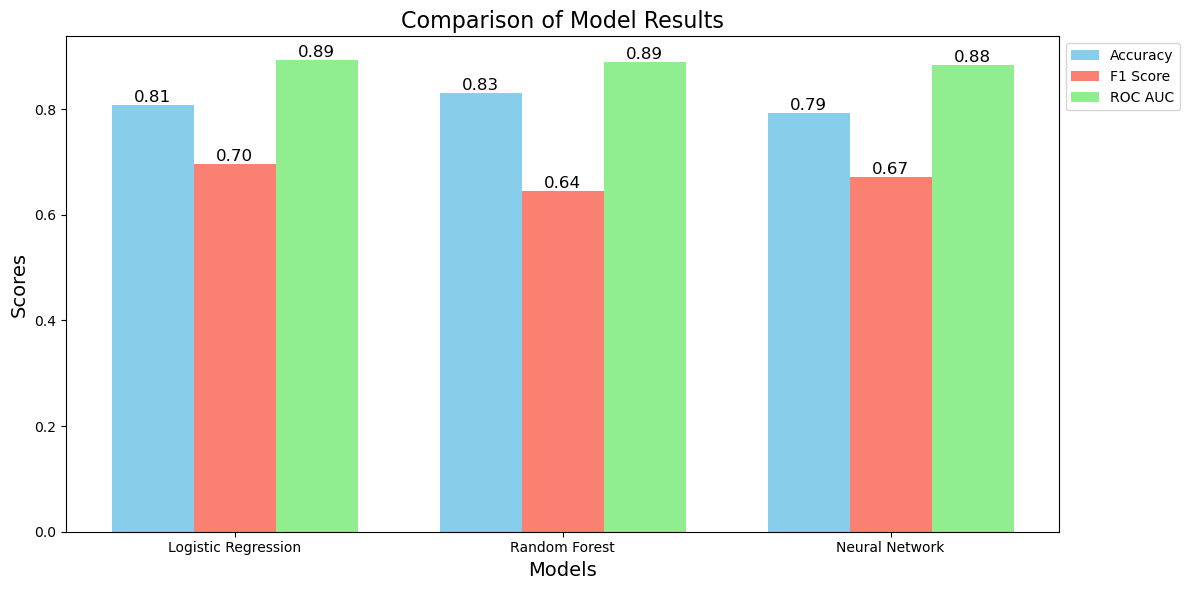

In [224]:
# Data from the previous results dictionary
model_names = list(results.keys())
accuracies = [metrics['Accuracy'] for metrics in results.values()]
f1_scores = [metrics['F1 Score'] for metrics in results.values()]
roc_auc_scores = [metrics['ROC AUC'] for metrics in results.values()] 

bar_width = 0.25  
x = np.arange(len(model_names))  

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - bar_width, accuracies, bar_width, label='Accuracy', color='skyblue')
bars2 = ax.bar(x, f1_scores, bar_width, label='F1 Score', color='salmon')
bars3 = ax.bar(x + bar_width, roc_auc_scores, bar_width, label='ROC AUC', color='lightgreen')  

ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Comparison of Model Results', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(model_names)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) 

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

for bar in bars3:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

**Predict class for 25000 instances using the best models**

Training Data Class Distribution:
Income
0.0    0.7558
1.0    0.2442
Name: proportion, dtype: float64
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


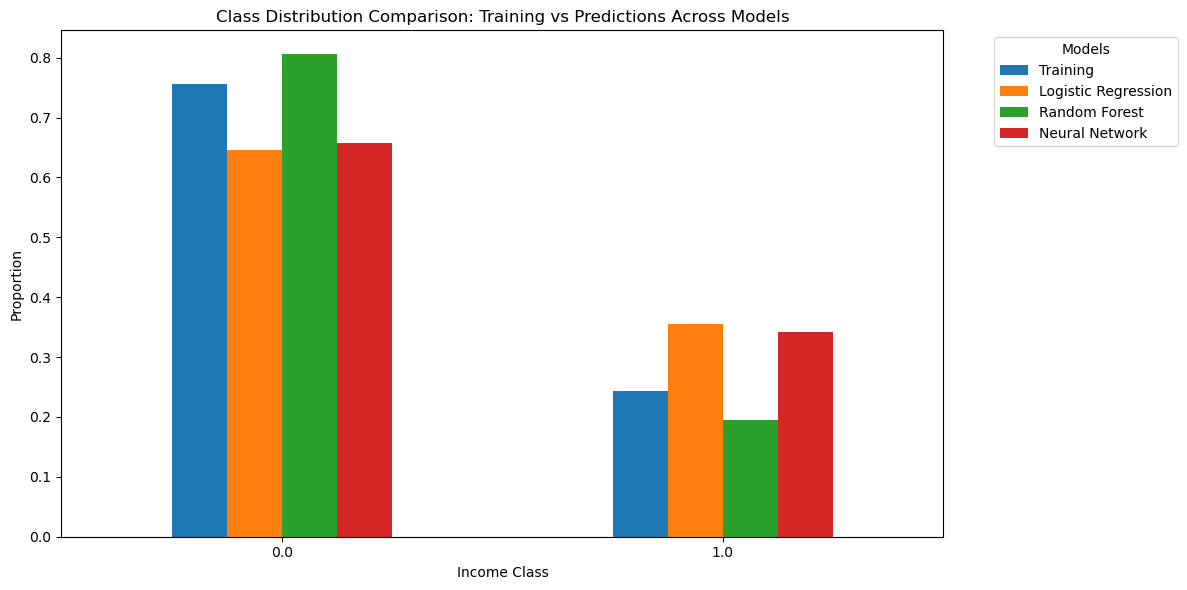


Combined Class Distributions:
     Training  Logistic Regression  Random Forest  Neural Network
0.0    0.7558              0.64512        0.80544         0.65732
1.0    0.2442              0.35488        0.19456         0.34268

Combined Jensen-Shannon Divergence:
Logistic Regression: 0.1028
Random Forest: 0.051
Neural Network: 0.092


In [227]:
from scipy.spatial.distance import jensenshannon

#Creating unlabeled DataFrame 
final_df_unlabeled = final_df[final_df['Income'].isna()]

#Prepare DataFrame for model predictions
final_df_unlabeled_wio = final_df_unlabeled.drop('Income', axis=1)

model_predictions = {}

# Dictionary for Jensen-Shannon divergences
divergences = {}

# Calculate class distribution in the training data
training_class_distribution = final_df_labeled['Income'].value_counts(normalize=True)
print("Training Data Class Distribution:")
print(training_class_distribution)

# Predict the income group for each model
for model_name, model in models.items():
    if model_name == "Neural Network":
        income_predictions = model.predict(final_df_unlabeled_wio).flatten()  
        income_predictions = (income_predictions > 0.5).astype(int)  
    else:
        income_predictions = model.predict(final_df_unlabeled_wio)

    model_predictions[model_name] = income_predictions

    predicted_class_distribution = pd.Series(income_predictions).value_counts(normalize=True)

    js_divergence = jensenshannon(training_class_distribution, predicted_class_distribution, base=2) 
    
    divergences[model_name] = round(js_divergence, 4)

predicted_distributions = pd.DataFrame()

# Calculate class distribution for each model's predictions 
for model_name, predictions in model_predictions.items():
    predicted_class_distribution = pd.Series(predictions).value_counts(normalize=True)
    predicted_distributions[model_name] = predicted_class_distribution

combined_distribution_df = pd.concat([training_class_distribution, predicted_distributions], axis=1)
combined_distribution_df.columns = ['Training'] + list(model_predictions.keys())

# Fill NaN values with 0 for better visualization
combined_distribution_df.fillna(0, inplace=True)

combined_distribution_df.plot(kind='bar', figsize=(12, 6))
plt.title('Class Distribution Comparison: Training vs Predictions Across Models')
plt.xlabel('Income Class')
plt.ylabel('Proportion')
plt.xticks(rotation=0)  
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()  
plt.show()

print("\nCombined Class Distributions:")
print(combined_distribution_df)

print("\nCombined Jensen-Shannon Divergence:")
for model_name, divergence in divergences.items():
    print(f"{model_name}: {divergence}")